In [1]:
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import corpus_bleu
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BartTokenizer, \
    BartForConditionalGeneration
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Load your train and validation datasets

In [2]:
# Load your train and validation datasets
num_row = 2000

train_df = pd.read_csv("resources/train.csv", nrows=num_row)
val_df = pd.read_csv("resources/validation.csv", nrows=num_row)

In [3]:
print(train_df.head())

                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  
0  Bishop John Folda, of North Dakota, is taking ...  
1  Criminal complaint: Cop used his role to help ...  
2  Craig Eccleston-Todd, 27, had drunk at least t...  
3  Nina dos Santos says Europe must be ready to a...  
4  Fleetwood top of League One after 2-0 win at S...  


### Preprocessing:

In [4]:
train_df['article'] = train_df['article'].str.lower()
val_df['article'] = val_df['article'].str.lower()

train_texts = train_df['article'].tolist()
train_labels = train_df['highlights'].tolist()

val_texts = val_df['article'].tolist()
val_labels = val_df['highlights'].tolist()

In [5]:
print("Sample highlight:", train_labels[0])  # Should not be 0 or empty
print("Sample article:", train_texts[0]) 

Sample highlight: Bishop John Folda, of North Dakota, is taking time off after being diagnosed .
He contracted the infection through contaminated food in Italy .
Church members in Fargo, Grand Forks and Jamestown could have been exposed .
Sample article: by . associated press . published: . 14:11 est, 25 october 2013 . | . updated: . 15:36 est, 25 october 2013 . the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda (pictured) of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it's important to alert people to th

In [6]:
print("Train Labels Sample:", train_labels[:5])


Train Labels Sample: ['Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .', 'Criminal complaint: Cop used his role to help cocaine traffickers .\nRalph Mata, an internal affairs lieutenant, allegedly helped group get guns .\nHe also arranged to pay two assassins in a murder plot, a complaint alleges .', "Craig Eccleston-Todd, 27, had drunk at least three pints before driving car .\nWas using phone when he veered across road in Yarmouth, Isle of Wight .\nCrashed head-on into 28-year-old Rachel Titley's car, who died in hospital .\nPolice say he would have been over legal drink-drive limit at time of crash .\nHe was found guilty at Portsmouth Crown Court of causing death by dangerous driving .", "Nina dos Santos says Europe must be ready to accept sanctions will hurt both sides .\nTargeting Russia's business community 

In [7]:
# Check if the target summaries are in train_labels
print(f"Train label for first article: {train_labels[0]}")  # Should show the summary, not 0


Train label for first article: Bishop John Folda, of North Dakota, is taking time off after being diagnosed .
He contracted the infection through contaminated food in Italy .
Church members in Fargo, Grand Forks and Jamestown could have been exposed .


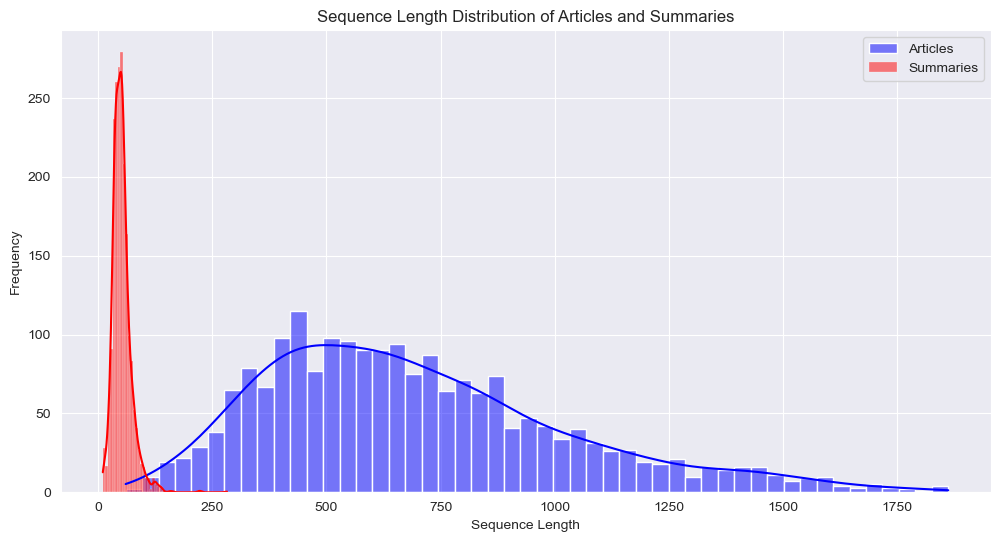

In [8]:
train_article_lengths = [len(text.split()) for text in train_texts]
train_summary_lengths = [len(text.split()) for text in train_labels]

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.histplot(train_article_lengths, bins=50, kde=True, color='blue', label='Articles')
sns.histplot(train_summary_lengths, bins=50, kde=True, color='red', label='Summaries')
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Sequence Length Distribution of Articles and Summaries")
plt.legend()
plt.show()

### Tokenizer

In [8]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base').to("cuda")

In [9]:
# Example: Find the average length of sequences
avg_length = np.mean([len(text.split()) for text in train_texts])
print(f"Average sequence length: {avg_length}")


Average sequence length: 694.314


### Create a Dataset class to handle the data more easily

In [15]:
class SummarizationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=100):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Ensure text and label are valid strings
        if not isinstance(text, str) or not isinstance(label, str):
            text = ""
            label = ""

        # Tokenize the article (input text)
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        
        # Tokenize the summary (target text)
        label_encoding = self.tokenizer(label, truncation=True, padding='max_length', max_length=self.max_length, return_tensors="pt")
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': label_encoding['input_ids'].squeeze(0)
        }

    def __len__(self):
        return len(self.texts)


### Prepare DataLoader

In [16]:
train_dataset = SummarizationDataset(train_texts, train_labels, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = SummarizationDataset(val_texts, val_labels, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=16, num_workers=2, pin_memory=True)

### Load a Pretrained BERT Model

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

#### Training loop

In [18]:
from nltk.translate.bleu_score import SmoothingFunction
import torch

def calculate_bleu(predictions, references, smoothing_function=None):
    predictions = [pred.split() for pred in predictions]  # Convert predictions to list of words
    references = [[ref.split()] for ref in references]  # Convert references to list of lists of words
    return corpus_bleu(references, predictions, smoothing_function=smoothing_function)



In [19]:
from transformers import get_linear_schedule_with_warmup

# Training loop
epochs = 3
train_steps = len(train_dataloader) * epochs
scaler = torch.amp.GradScaler()

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=train_steps)

gradient_accumulation_steps = 2  # Accumulate gradients over 4 steps
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Move to GPU
        batch = {k: v.to("cuda") for k, v in batch.items()}

        # Mixed precision training: use autocast for forward and loss calculation
        with torch.amp.autocast("cuda"):
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            loss = outputs.loss

        # Scale loss and accumulate gradients
        scaler.scale(loss).backward()

        # Accumulate gradients and update optimizer every gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()  # Update scheduler after every optimizer step

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to("cuda", non_blocking=True) for k, v in batch.items()}
    
            with torch.amp.autocast("cuda"):
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
                val_loss += outputs.loss.item()
    
            # Generate model predictions
            summary_ids = model.generate(batch['input_ids'], num_beams=2, max_length=100, early_stopping=True)
            summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
            val_preds.extend(summaries)
    
            val_labels_list.extend(tokenizer.batch_decode(batch['labels'], skip_special_tokens=True))
    
    # Compute BLEU Score
    smoothing_function = SmoothingFunction().method4
    bleu_score = calculate_bleu(val_preds, val_labels_list, smoothing_function)

    print(f"Epoch {epoch+1}/{epochs} Train Loss: {avg_train_loss:.4f} BLEU Score: {bleu_score:.4f}")


Epoch 1/3 Train Loss: 4.3996 BLEU Score: 0.0773
Epoch 2/3 Train Loss: 3.5398 BLEU Score: 0.0954
Epoch 3/3 Train Loss: 3.1271 BLEU Score: 0.0970


### Saving model

In [24]:
model.save_pretrained("summarization_model")
tokenizer.save_pretrained("summarization_model")
print("Model saved to bart_model.pth")

Model saved to bart_model.pth


### Function to generate a summary from the trained model

In [25]:
def generate_summary(text, model, tokenizer, max_length=150):
    # Preprocess and tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True, padding="max_length")
    
    # Generate the summary using the trained model
    summary_ids = model.generate(inputs['input_ids'].to("cuda"), num_beams=4, max_length=max_length, early_stopping=True)
    
    # Print the summary IDs to understand the output
    print(f"Generated Token IDs: {summary_ids}")

    # Decode the summary and return it
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [26]:
generated_summary = generate_summary(train_texts[0], model, tokenizer)
print(f"Generated Summary: '{generated_summary}'")  # Notice the quotes to identify if it's just whitespace


Generated Token IDs: tensor([[    2,     0,   387, 44517,   610, 41303,   102,    34,    57,  6443,
            19, 24426,    83,  6793,   479, 50118,   894,    34,    57,  4924,
             7, 24426,    83,  7910,    11,    39,   184,    11,  1261,   479,
             2]], device='cuda:0')
Generated Summary: 'Bishop John Folda has been diagnosed with hepatitis A virus .
He has been exposed to hepatitis A infection in his home in Florida .'


In [27]:
print("Sample article:", train_texts[0])
print("Sample highlight:", train_labels[0])


Sample article: by . associated press . published: . 14:11 est, 25 october 2013 . | . updated: . 15:36 est, 25 october 2013 . the bishop of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a virus in late september and early october. the state health department has issued an advisory of exposure for anyone who attended five churches and took communion. bishop john folda (pictured) of the fargo catholic diocese in north dakota has exposed potentially hundreds of church members in fargo, grand forks and jamestown to the hepatitis a . state immunization program manager molly howell says the risk is low, but officials feel it's important to alert people to the possible exposure. the diocese announced on monday that bishop john folda is taking time off after being diagnosed with hepatitis a. the diocese says he contracted the infection through contaminated food while attending a conference for 